CLEARING COLAB CACHE DATA

In [ ]:
!free -h
%reset -f
%env PYDEVD_DISABLE_FILE_VALIDATION=1


               total        used        free      shared  buff/cache   available
Mem:            12Gi       813Mi       6.5Gi       1.0Mi       5.4Gi        11Gi
Swap:             0B          0B          0B
env: PYDEVD_DISABLE_FILE_VALIDATION=1


IMPORTING NECESSARY LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')


LOADING DATASET THROUGH GOOGLE DRIVE


In [ ]:
import os
import gdown
import pandas as pd
from google.colab import drive

# Set up output directory
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Mount Google Drive
drive.mount('/content/drive')

# Google Drive file ID (Extracted from the shareable link)
file_id = "1gklVZyWsocAskqSf2xjssH-0bGm47emQ"  # Replace with your actual file ID
file_path = "southeast.csv"

# Download the file from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_path, quiet=False)

# Load the dataset
df = pd.read_csv(file_path)

# Function to reduce dataset size
def reduce_dataset_size(df, percentage=0.001):
    return df.sample(frac=percentage, random_state=42)  # Ensures reproducibility

# Reduce dataset size
df = reduce_dataset_size(df, percentage=0.001)


Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=1gklVZyWsocAskqSf2xjssH-0bGm47emQ
From (redirected): https://drive.google.com/uc?id=1gklVZyWsocAskqSf2xjssH-0bGm47emQ&confirm=t&uuid=8adf4ac8-8d94-4066-8766-40687c9008eb
To: /content/southeast.csv
100%|██████████| 2.49G/2.49G [00:19<00:00, 126MB/s]


In [ ]:
# Set random seeds for reproducibility
np.random.seed(32)
torch.manual_seed(32)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


LOADING DATA FUNCTION, EDA FUNCTION, COLUMN MAPPING FUNCTION, PRE-PROCESSING DATA AND CREATING SEQUENCES


In [ ]:

def load_data(file_path, columns=None):
    """Load and prepare the Brazilian weather dataset with optimizations."""
    # Only load necessary columns if specified
    if columns:
        df = pd.read_csv(file_path, usecols=columns)
    else:
        df = pd.read_csv(file_path)

    # More efficient datetime parsing
    if 'Data' in df.columns and 'Hora' in df.columns:
        # Use faster datetime parsing method
        df['date'] = pd.to_datetime(df['Data'] + ' ' + df['Hora'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)

        # Drop original date columns to save memory
        df.drop(['Data', 'Hora'], axis=1, inplace=True)

    return df

def get_column_mapping():
    """Return the column mapping dictionary."""
    return {
        'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'precipitation',
        'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'air_pressure',
        'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'max_air_pressure',
        'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'min_air_pressure',
        'RADIACAO GLOBAL (Kj/m²)': 'solar_radiation',
        'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'air_temperature',
        'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'dew_point_temperature',
        'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'max_temperature',
        'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'min_temperature',
        'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'max_dew_point',
        'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'min_dew_point',
        'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'max_humidity',
        'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'min_humidity',
        'UMIDADE RELATIVA DO AR, HORARIA (%)': 'air_humidity',
        'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'wind_direction',
        'VENTO, RAJADA MAXIMA (m/s)': 'max_wind_gust',
        'VENTO, VELOCIDADE HORARIA (m/s)': 'wind_speed',
        'region': 'region',
        'state': 'state',
        'station': 'station',
        'station_code': 'station_code',
        'latitude': 'latitude',
        'longitude': 'longitude',
        'height': 'height'
    }

def perform_eda(df, plot=True, sample_size=None):
    """Perform advanced exploratory data analysis on the weather dataset."""
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Ensure required libraries are imported
    plt.style.use('ggplot')  # Optional: use a more visually appealing style

    # Get column mapping (now we know this function exists)
    column_mapping = get_column_mapping()

    # Dataset Overview
    print(f"Dataset Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Efficient missing values computation
    missing_values = df.isna().sum()
    missing_summary = missing_values[missing_values > 0].to_frame(name="Missing Count")
    if not missing_summary.empty:
        missing_summary["Missing %"] = (missing_summary["Missing Count"] / len(df)) * 100
    print("\n🔹 Missing Values Summary:")
    print(missing_summary if not missing_summary.empty else "✅ No missing values.")

    # Descriptive Statistics
    print("\n🔹 Summary Statistics for Numeric Features:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        desc_stats = df[numeric_cols].describe().T
        desc_stats["skew"] = df[numeric_cols].skew()
        desc_stats["kurtosis"] = df[numeric_cols].kurtosis()
        print(desc_stats)
    else:
        print("No numeric columns found in the dataset.")

    # Detect outliers using IQR method
    if numeric_cols:
        Q1 = df[numeric_cols].quantile(0.25)
        Q3 = df[numeric_cols].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
        outlier_summary = outliers[outliers > 0].to_frame(name="Outlier Count")
        print("\n🔹 Outlier Summary (IQR Method):")
        print(outlier_summary if not outlier_summary.empty else "✅ No significant outliers.")

    # Time-Series Analysis (if applicable)
    time_col = None
    if 'date' in df.columns:
        time_col = 'date'
    elif 'timestamp' in df.columns:
        time_col = 'timestamp'
    elif 'Data' in df.columns:  # Portuguese for date
        time_col = 'Data'

    if time_col:
        # Make a copy to avoid SettingWithCopyWarning
        df = df.copy()
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')  # Ensure it's datetime with error handling

        # Extract time components
        try:
            df["year"] = df[time_col].dt.year
            df["month"] = df[time_col].dt.month
            df["day"] = df[time_col].dt.day
            df["hour"] = df[time_col].dt.hour
        except:
            print(f"⚠️ Warning: Could not extract all time components from {time_col}")
            # Try to extract what we can
            if hasattr(df[time_col].dt, 'year'):
                df["year"] = df[time_col].dt.year
            if hasattr(df[time_col].dt, 'month'):
                df["month"] = df[time_col].dt.month

        print("\n🔹 Time-Based Analysis:")
        if "year" in df.columns:
            print(df.groupby("year").size().to_frame(name="Records per Year"))
        if "month" in df.columns:
            print(df.groupby("month").size().to_frame(name="Records per Month").T)

    # Categorical Features Analysis
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    print("\n🔹 Categorical Feature Analysis:")
    for col in categorical_cols:
        print(f"\nFeature: {col}")
        print(df[col].value_counts().head(5))  # Show top 5 categories

    # Plotting only if requested
    if plot:
        print("\n🔹 Generating Plots:")

        # Create a sample if requested and if it's smaller than the dataset
        if sample_size and sample_size < len(df):
            print(f"Using a sample of {sample_size} records for visualization")
            vis_df = df.sample(sample_size)
        else:
            vis_df = df.copy()

        # Create a working copy with mapped column names
        plot_df = vis_df.copy()

        # Apply column mapping to create new columns with standardized names
        for orig_col, simple_col in column_mapping.items():
            if orig_col in plot_df.columns:
                plot_df[simple_col] = plot_df[orig_col]
                print(f"Mapped '{orig_col}' → '{simple_col}'")

        # Define key features we want to visualize
        key_features = ['air_temperature', 'air_humidity', 'wind_speed',
                       'air_pressure', 'precipitation', 'solar_radiation',
                       'dew_point_temperature', 'max_wind_gust']

        # Find the available key features in our mapped dataframe
        available_key_features = [col for col in key_features if col in plot_df.columns]

        print(f"Found {len(available_key_features)} key features for plotting: {available_key_features}")

        if available_key_features:
            # Distribution Plots
            n_features = min(4, len(available_key_features))
            features_to_plot = available_key_features[:n_features]

            fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=100)
            axes = axes.flatten()

            for i, feature in enumerate(features_to_plot):
                # Check if we have non-null data to plot
                feature_data = plot_df[feature].dropna()
                if len(feature_data) > 0:
                    sns.histplot(feature_data, kde=True, bins=25, ax=axes[i])
                    axes[i].set_title(f'Distribution of {feature}')
                    print(f"Plotted distribution for {feature} with {len(feature_data)} data points")
                else:
                    axes[i].text(0.5, 0.5, f"No data for {feature}",
                               horizontalalignment='center', verticalalignment='center')
                    print(f"⚠️ No data available for {feature}")

            # Hide unused axes
            for j in range(n_features, 4):
                axes[j].set_visible(False)

            plt.tight_layout()
            plt.savefig('feature_distributions.png')
            plt.show()
            print("✅ Feature distribution plots created and saved as 'feature_distributions.png'")

            # Correlation Matrix
            if len(available_key_features) > 1:
                # Check if we have enough non-null data for correlation
                corr_df = plot_df[available_key_features].dropna()
                if len(corr_df) > 0:
                    correlation = corr_df.corr()
                    plt.figure(figsize=(10, 8), dpi=100)
                    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5,
                              annot_kws={"size": 8})
                    plt.title('Correlation Matrix of Key Weather Features')
                    plt.tight_layout()
                    plt.savefig('correlation_matrix.png')
                    plt.show()
                    print("✅ Correlation matrix created and saved as 'correlation_matrix.png'")
                else:
                    print("⚠️ Not enough complete data rows to create correlation matrix")

            # Time-Series Plot
            if time_col and 'air_temperature' in plot_df.columns:
                # Ensure time column is datetime
                plot_df[time_col] = pd.to_datetime(plot_df[time_col], errors='coerce')

                # Get data for time series, dropping any NaN values
                ts_data = plot_df[[time_col, 'air_temperature']].dropna()

                if len(ts_data) > 0:
                    plt.figure(figsize=(12, 5))
                    sns.lineplot(x=ts_data[time_col], y=ts_data['air_temperature'])
                    plt.title('Temperature Trend Over Time')
                    plt.xlabel('Time')
                    plt.ylabel('Air Temperature (°C)')
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.savefig('temperature_trend.png')
                    plt.show()
                    print("✅ Temperature trend plot created and saved as 'temperature_trend.png'")
                else:
                    print("⚠️ Not enough data for temperature time series plot")

                    # Try another feature if air_temperature is empty
                    for feature in available_key_features:
                        ts_data = plot_df[[time_col, feature]].dropna()
                        if len(ts_data) > 0:
                            plt.figure(figsize=(12, 5))
                            sns.lineplot(x=ts_data[time_col], y=ts_data[feature])
                            plt.title(f'{feature} Trend Over Time')
                            plt.xlabel('Time')
                            plt.ylabel(feature)
                            plt.xticks(rotation=45)
                            plt.tight_layout()
                            plt.savefig(f'{feature}_trend.png')
                            plt.show()
                            print(f"✅ {feature} trend plot created as fallback")
                            break
        else:
            print("⚠️ No key features found in the dataset, can't generate plots")

            # Try plotting any numeric columns as fallback
            numeric_cols = plot_df.select_dtypes(include=[np.number]).columns.tolist()
            if numeric_cols and len(numeric_cols) >= 2:
                print(f"Attempting to plot using available numeric columns: {numeric_cols[:4]}")

                # Distribution plots
                fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=100)
                axes = axes.flatten()

                for i, col in enumerate(numeric_cols[:4]):
                    if i < 4:  # Only plot up to 4 columns
                        col_data = plot_df[col].dropna()
                        if len(col_data) > 0:
                            sns.histplot(col_data, kde=True, bins=25, ax=axes[i])
                            axes[i].set_title(f'Distribution of {col}')

                plt.tight_layout()
                plt.savefig('numeric_distributions.png')
                plt.show()
                print("✅ Created fallback distribution plots")

                # Correlation matrix
                corr_df = plot_df[numeric_cols].dropna()
                if len(corr_df) > 0:
                    correlation = corr_df.corr()
                    plt.figure(figsize=(10, 8), dpi=100)
                    sns.heatmap(correlation, annot=True, cmap='coolwarm',
                              linewidths=0.5, annot_kws={"size": 8})
                    plt.title('Correlation Matrix of Numeric Features')
                    plt.tight_layout()
                    plt.savefig('numeric_correlation.png')
                    plt.show()
                    print("✅ Created fallback correlation matrix")

    return plot_df if plot else None


def preprocess_data(df, features=None, include_categorical=False):
    """Preprocess the weather data for model training with optimizations."""
    column_mapping = get_column_mapping()

    # Only copy the dataframe if we need to add new columns
    if features is None or set(features).issubset(df.columns):
        processed_df = df
    else:
        processed_df = df.copy()

    # Create new columns with simplified names only if necessary
    created_columns = []
    for orig_col, simple_col in column_mapping.items():
        if orig_col in processed_df.columns and simple_col not in processed_df.columns:
            processed_df[simple_col] = processed_df[orig_col]
            created_columns.append(simple_col)

    # Handle categorical features if needed and not already in features
    if include_categorical:
        categorical_cols = ['region', 'state', 'station']
        dummy_cols = []

        for col in categorical_cols:
            if col in processed_df.columns:
                # Use more efficient get_dummies
                dummies = pd.get_dummies(processed_df[col], prefix=col, sparse=True)
                # Add to the processed dataframe
                processed_df = pd.concat([processed_df, dummies], axis=1)
                dummy_cols.extend(dummies.columns.tolist())

    # If features are not specified, use all numerical columns
    if features is None:
        # Get all simplified column names that have numerical data
        numerical_cols = [col for col in column_mapping.values()
                          if col in processed_df.columns and
                          processed_df[col].dtype in [np.int64, np.float64]]

        # If include_categorical is True, add the dummy columns
        if include_categorical:
            features = numerical_cols + dummy_cols
        else:
            features = numerical_cols

    # Extract only the needed features for processing
    data = processed_df[features]

    # Handle missing values - Using more efficient methods
    # First check if there are missing values to avoid unnecessary operations
    if data.isnull().sum().sum() > 0:
        # Fill missing values - forward fill then backward fill
        data = data.fillna(method='ffill').fillna(method='bfill')

        # Check if there are still missing values after filling
        remaining_nulls = data.isnull().sum().sum()
        if remaining_nulls > 0:
            # For any remaining missing values, fill with column mean
            column_means = data.mean()
            data = data.fillna(column_means)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

    # Clean up temporary columns if created
    if processed_df is df and created_columns:
        processed_df.drop(created_columns, axis=1, inplace=True)

    return scaled_df, scaler, features

def create_sequences(data, n_past, n_future, stride=1):
    """
    Create sequences for time series forecasting with optimization.

    Args:
        data: DataFrame or numpy array of the data
        n_past: Number of past time steps to use as input
        n_future: Number of future time steps to predict
        stride: Step size between samples (set higher to reduce data size)

    Returns:
        X: Input sequences [samples, timesteps, features]
        y: Target sequences [samples, n_future, features]
    """
    # Convert DataFrame to numpy array if needed
    if isinstance(data, pd.DataFrame):
        data_array = data.values
    else:
        data_array = data

    # Pre-allocate arrays for better memory efficiency
    n_samples = (len(data_array) - n_past - n_future + 1) // stride

    if n_samples <= 0:
        raise ValueError("Not enough data to create sequences with given parameters")

    # Get shape information
    n_features = data_array.shape[1] if data_array.ndim > 1 else 1

    # Pre-allocate arrays
    X_shape = (n_samples, n_past, n_features)
    y_shape = (n_samples, n_future, n_features)

    X = np.zeros(X_shape)
    y = np.zeros(y_shape)

    # Fill arrays using strided indexing
    for i in range(n_samples):
        idx = i * stride
        X[i] = data_array[idx:idx + n_past]
        y[i] = data_array[idx + n_past:idx + n_past + n_future]

    return X, y

def split_data(X, y, train_ratio=0.7, val_ratio=0.15):
    """
    Split the data chronologically into train, validation, and test sets.

    Args:
        X: Input data
        y: Target data
        train_ratio: Proportion of data for training
        val_ratio: Proportion of data for validation

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    n = len(X)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)

    # Avoid unnecessary copies by using views
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test

def engineer_features(df, compute_rolling=True):
    """Create additional engineered features from the raw weather data with optimizations."""
    # Define key features to reduce computation
    key_features = [
        'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
        'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
        'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
        'TEMPERATURA DO PONTO DE ORVALHO (°C)',
        'UMIDADE RELATIVA DO AR, HORARIA (%)',
        'VENTO, VELOCIDADE HORARIA (m/s)',
        'VENTO, DIREÇÃO HORARIA (gr) (° (gr))'
    ]

    # Check which key features are present
    available_features = [col for col in key_features if col in df.columns]

    # Only copy the required columns to save memory
    eng_df = df.copy()

    # Define column mappings for simpler access
    column_mapping = {
        'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'precipitation',
        'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'air_pressure',
        'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'air_temperature',
        'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'dew_point_temperature',
        'UMIDADE RELATIVA DO AR, HORARIA (%)': 'air_humidity',
        'VENTO, VELOCIDADE HORARIA (m/s)': 'wind_speed',
        'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'wind_direction'
    }

    # Map original columns to simplified names
    for orig_col, simple_col in column_mapping.items():
        if orig_col in eng_df.columns:
            eng_df[simple_col] = eng_df[orig_col]

    # Extract time-based features efficiently
    eng_df['hour'] = eng_df.index.hour
    eng_df['day'] = eng_df.index.day
    eng_df['month'] = eng_df.index.month
    eng_df['day_of_week'] = eng_df.index.dayofweek
    eng_df['is_weekend'] = eng_df['day_of_week'].isin([5, 6]).astype(int)

    # Use vectorized operations for sine/cosine features
    eng_df['hour_sin'] = np.sin(2 * np.pi * eng_df['hour'] / 24)
    eng_df['hour_cos'] = np.cos(2 * np.pi * eng_df['hour'] / 24)
    eng_df['month_sin'] = np.sin(2 * np.pi * eng_df['month'] / 12)
    eng_df['month_cos'] = np.cos(2 * np.pi * eng_df['month'] / 12)

    # Calculate temperature-humidity index (heat index) if features exist
    has_temp = 'air_temperature' in eng_df.columns
    has_humidity = 'air_humidity' in eng_df.columns

    if has_temp and has_humidity:
        T = eng_df['air_temperature']
        RH = eng_df['air_humidity']

        # Vectorized calculation
        eng_df['heat_index'] = (-42.379 + 2.04901523*T + 10.14333127*RH -
                                0.22475541*T*RH - 0.00683783*T*T -
                                0.05481717*RH*RH + 0.00122874*T*T*RH +
                                0.00085282*T*RH*RH - 0.00000199*T*T*RH*RH)

    # Calculate wind chill if features exist
    has_wind = 'wind_speed' in eng_df.columns

    if has_temp and has_wind:
        T = eng_df['air_temperature']
        V = eng_df['wind_speed']

        # Create mask for valid wind chill conditions
        mask = (T < 10) & (V > 1.3)

        # Only calculate for relevant rows to save computation
        if mask.any():
            eng_df['wind_chill'] = np.nan
            # Vectorized calculation only where needed
            eng_df.loc[mask, 'wind_chill'] = 13.12 + 0.6215*T[mask] - 11.37*V[mask]**0.16 + 0.3965*T[mask]*V[mask]**0.16

    # Calculate dew point depression
    has_dew = 'dew_point_temperature' in eng_df.columns

    if has_temp and has_dew:
        eng_df['dew_point_depression'] = eng_df['air_temperature'] - eng_df['dew_point_temperature']

    # Calculate rolling features only if requested (they're computationally expensive)
    if compute_rolling:
        if has_temp:
            eng_df['temp_24h_avg'] = eng_df['air_temperature'].rolling(window=24, min_periods=1).mean()
            eng_df['temp_24h_std'] = eng_df['air_temperature'].rolling(window=24, min_periods=1).std()

        if 'precipitation' in eng_df.columns:
            eng_df['precip_24h_sum'] = eng_df['precipitation'].rolling(window=24, min_periods=1).sum()

    return eng_df

def reduce_dataset_size(df, percentage=0.4, method='chunk'):
    """
    Reduce the size of the dataset to a specified percentage.

    Args:
        df: The original DataFrame
        percentage: Percentage of data to keep (between 0 and 1)
        method: 'chunk' for a continuous chunk, 'stride' for regular sampling,
                'random' for random sampling

    Returns:
        A reduced version of the DataFrame
    """
    if not (0 < percentage <= 1):
        raise ValueError("Percentage must be between 0 and 1")

    n = len(df)
    n_samples = int(n * percentage)

    if n_samples >= n:
        return df.copy()  # Return full dataset if percentage is too high

    if method == 'chunk':
        # Take a continuous chunk from the start
        reduced_df = df.iloc[:n_samples].copy()

    elif method == 'stride':
        # Take regular samples throughout the dataset
        stride = max(1, int(1 / percentage))
        reduced_df = df.iloc[::stride].copy()

        # Trim to exact percentage if needed
        if len(reduced_df) > n_samples:
            reduced_df = reduced_df.iloc[:n_samples]

    elif method == 'random':
        # Take random samples
        reduced_df = df.sample(n=n_samples).sort_index().copy()

    else:
        raise ValueError("Method must be 'chunk', 'stride', or 'random'")

    print(f"Original dataset size: {n} samples")
    print(f"Reduced dataset size: {len(reduced_df)} samples ({percentage*100:.1f}% of original)")

    return reduced_df

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, device='cpu'):
        # Convert to torch tensors only when needed
        self.X = X  # Keep as numpy array
        self.y = y  # Keep as numpy array
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Convert to tensor only when item is requested
        X_tensor = torch.tensor(self.X[idx], dtype=torch.float32).to(self.device)

        if self.y is not None:
            y_tensor = torch.tensor(self.y[idx], dtype=torch.float32).to(self.device)
            return X_tensor, y_tensor
        else:
            return X_tensor

def process_weather_data(file_path, reduce_size=True, size_percentage=0.4,
                        n_past=24, n_future=12, include_categorical=False,
                        perform_feature_engineering=True, plot=False):
    """
    Complete end-to-end optimized processing pipeline for weather data.

    Args:
        file_path: Path to the CSV file
        reduce_size: Whether to reduce dataset size
        size_percentage: Percentage of data to keep if reducing
        n_past: Number of past time steps for sequences
        n_future: Number of future time steps to predict
        include_categorical: Whether to include categorical features
        perform_feature_engineering: Whether to perform feature engineering
        plot: Whether to generate plots during EDA

    Returns:
        Dictionary containing processed data and metadata
    """
    print("Step 1: Loading data...")
    df = load_data(file_path)

    if reduce_size and size_percentage < 1.0:
        print(f"Step 2: Reducing dataset size to {size_percentage*100:.1f}%...")
        df = reduce_dataset_size(df, percentage=size_percentage, method='stride')

    print("Step 3: Performing exploratory data analysis...")
    _ = perform_eda(df, plot=plot, sample_size=10000 if len(df) > 10000 else None)

    if perform_feature_engineering:
        print("Step 4: Engineering features...")
        df = engineer_features(df, compute_rolling=True)

    print("Step 5: Preprocessing data...")
    scaled_df, scaler, features = preprocess_data(df, include_categorical=include_categorical)

    print(f"Step 6: Creating sequences (past={n_past}, future={n_future})...")
    # Use a stride of 2 to further reduce data size
    X, y = create_sequences(scaled_df, n_past=n_past, n_future=n_future, stride=2)

    print("Step 7: Splitting data...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    print("Step 8: Creating PyTorch datasets...")
    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset = TimeSeriesDataset(X_val, y_val)
    test_dataset = TimeSeriesDataset(X_test, y_test)

    # Return all processing results
    results = {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'scaler': scaler,
        'features': features,
        'n_features': X.shape[2],
        'n_past': n_past,
        'n_future': n_future
    }

    print("Data processing complete!")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Testing samples: {len(X_test)}")

    return results

VARIATIONAL AUTOENCODER CLASS DECLARATION, WITH TRAIN, ANOMALY DETECT, EVALUATE, ANALYZE LATENT SPACE AND GENERATE SYNTHETIC DATA FUNCTION

In [ ]:

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], latent_dim=16):
        super(VAE, self).__init__()

        # Encoder layers
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = hidden_dim

        # Mean and log variance layers
        self.encoder = nn.Sequential(*encoder_layers)
        self.mu_layer = nn.Linear(hidden_dims[-1], latent_dim)
        self.logvar_layer = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder layers
        decoder_layers = []
        prev_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, hidden_dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = hidden_dim
        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))

        self.decoder = nn.Sequential(*decoder_layers)

        self.latent_dim = latent_dim

    def encode(self, x):
        h = self.encoder(x)
        return self.mu_layer(h), self.logvar_layer(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')

        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = recon_loss + kl_loss

        return loss, recon_loss, kl_loss

def train_vae(model, train_loader, val_loader, epochs=100, lr=1e-2, device=device):
    """Train the VAE model for anomaly detection."""
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    counter = 0

    for epoch in tqdm(range(epochs)):
        # Training phase
        model.train()
        train_loss = 0
        train_recon_loss = 0
        train_kl_loss = 0

        for batch_idx, (x,_) in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(x)
            loss, recon_loss, kl_loss = model.loss_function(recon_batch, x, mu, logvar)

            loss.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            train_loss += loss.item()
            train_recon_loss += recon_loss.item()
            train_kl_loss += kl_loss.item()

        # Average losses for the epoch
        train_loss /= len(train_loader.dataset)
        train_recon_loss /= len(train_loader.dataset)
        train_kl_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        val_recon_loss = 0
        val_kl_loss = 0

        with torch.no_grad():
            for batch_idx, (x,_) in enumerate(val_loader):
                x = x.to(device)

                recon_batch, mu, logvar = model(x)
                loss, recon_loss, kl_loss = model.loss_function(recon_batch, x, mu, logvar)

                val_loss += loss.item()
                val_recon_loss += recon_loss.item()
                val_kl_loss += kl_loss.item()

        # Average validation losses
        val_loss /= len(val_loader.dataset)
        val_recon_loss /= len(val_loader.dataset)
        val_kl_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print progress
        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.4f} (Recon: {train_recon_loss:.4f}, KL: {train_kl_loss:.4f}) | '
              f'Val Loss: {val_loss:.4f} (Recon: {val_recon_loss:.4f}, KL: {val_kl_loss:.4f})')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_vae_model.pth')
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('VAE Training and Validation Loss')
    plt.legend()
    plt.ylim(0, 1000)
    plt.grid(True)
    plt.savefig('vae_training_loss.png')
    plt.show()

    # Load the best model
    model.load_state_dict(torch.load('best_vae_model.pth'))

    return model, train_losses, val_losses


def detect_anomalies(model, data_loader, threshold=None, device=device):
    """
    Detect anomalies using the trained VAE model.

    Args:
        model: Trained VAE model
        data_loader: DataLoader containing the data to check for anomalies
        threshold: Threshold for anomaly detection (if None, calculated using validation set)

    Returns:
        anomaly_scores: List of anomaly scores for each data point
        anomalies: Boolean array indicating anomalies
        threshold: Used or calculated threshold
    """
    model.eval()
    all_recon_errors = []

    with torch.no_grad():
        for batch_idx, (x,_) in enumerate(data_loader):
            x = x.to(device)

            recon_x, _, _ = model(x)
            # Reconstruction error as anomaly score (MSE)
            recon_error = F.mse_loss(recon_x, x, reduction='none').sum(dim=1).cpu().numpy()
            all_recon_errors.extend(recon_error)

    anomaly_scores = np.array(all_recon_errors)

    # If threshold not provided, calculate it based on the distribution of errors
    if threshold is None:
        # Using mean + 2*std as a threshold
        threshold = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)

    # Identify anomalies
    anomalies = anomaly_scores > threshold

    return anomaly_scores, anomalies, threshold

def visualize_anomalies(timestamps, data, anomaly_scores, anomalies, feature_names, threshold):
    """
    Visualize the detected anomalies.

    Args:
        timestamps: Time index for the data
        data: Original data values
        anomaly_scores: Array of anomaly scores
        anomalies: Boolean array indicating anomalies
        feature_names: List of feature names
        threshold: Threshold used for anomaly detection
    """
    # Plot the distribution of anomaly scores
    plt.figure(figsize=(10, 6))
    plt.hist(anomaly_scores, bins=50)
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.xlabel('Anomaly Score (Reconstruction Error)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Anomaly Scores')
    plt.legend()
    plt.savefig('anomaly_score_distribution.png')
    plt.close()

    # Plot time series with anomalies for key features
    n_features = min(3, len(feature_names))  # Plot at most 3 features

    plt.figure(figsize=(15, 4 * n_features))

    for i in range(n_features):
        feature = feature_names[i]
        plt.subplot(n_features, 1, i+1)

        # Plot the original data
        plt.plot(timestamps, data[:, i], label=feature)

        # Highlight anomalies
        anomaly_points = data[anomalies, i]
        anomaly_timestamps = timestamps[anomalies]
        plt.scatter(anomaly_timestamps, anomaly_points, color='red', marker='o', label='Anomalies')

        plt.title(f'{feature} Time Series with Anomalies')
        plt.xlabel('Time')
        plt.ylabel(feature)
        plt.legend()

    plt.tight_layout()
    plt.savefig('anomalies_time_series.png')
    plt.close()

    # Calculate percentage of anomalies
    anomaly_percentage = 100 * np.sum(anomalies) / len(anomalies)
    print(f'Percentage of detected anomalies: {anomaly_percentage:.2f}%')
    print(f'Number of anomalies: {np.sum(anomalies)} out of {len(anomalies)}')

    return


def evaluate_anomaly_detection(anomalies, ground_truth=None):
    """
    Evaluate the performance of anomaly detection.

    Args:
        anomalies: Boolean array of detected anomalies
        ground_truth: Boolean array of true anomalies (if available)

    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    metrics = {}

    # If ground truth is available, calculate precision, recall, and F1-score
    if ground_truth is not None:
        precision, recall, f1, _ = precision_recall_fscore_support(
            ground_truth, anomalies, average='binary')

        metrics['precision'] = precision
        metrics['recall'] = recall
        metrics['f1_score'] = f1

        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-Score: {f1:.4f}')
    else:
        # Without ground truth, just report the anomaly rate
        anomaly_rate = np.mean(anomalies)
        metrics['anomaly_rate'] = anomaly_rate
        print(f'Anomaly Rate: {anomaly_rate:.4f}')

    return metrics

def analyze_latent_space(model, data_loader, device):
    """Analyze the latent space representations using PCA."""
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in data_loader:
            if isinstance(batch, (list, tuple)):
                batch = batch[0]  # Extract first tensor if wrapped in list/tuple

            batch = batch.to(device)

            # Handle multiple outputs from the model
            model_output = model(batch)

            if isinstance(model_output, tuple) or isinstance(model_output, list):
                latent = model_output[1]  # Assume the second output is the latent representation
            else:
                raise ValueError("Unexpected model output format. Ensure it returns (recon, latent, *other)")

            latent_vectors.append(latent.cpu().numpy())  # Convert to NumPy

    # Convert list to NumPy array
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    print("Latent vector shape before PCA:", latent_vectors.shape)

    # Reduce seq_len dimension by averaging (if applicable)
    if len(latent_vectors.shape) == 3:
        latent_vectors_mean = latent_vectors.mean(axis=1)  # (batch, latent_dim)
    else:
        latent_vectors_mean = latent_vectors  # Already in correct shape

    # Apply PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors_mean)

    # Plot the PCA projection
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7, c=np.arange(len(latent_2d)), cmap='viridis')
    plt.colorbar(scatter, label="Sample Index")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("2D PCA Projection of Latent Space")
    plt.grid(True)
    plt.show()

    return latent_vectors_mean, latent_2d

def generate_synthetic_data(model, n_samples=100, device=device):
    """
    Generate synthetic weather data by sampling from the latent space.

    Args:
        model: Trained VAE model
        n_samples: Number of synthetic samples to generate

    Returns:
        synthetic_data: Generated synthetic data
    """
    model.eval()

    with torch.no_grad():
        # Sample from normal distribution
        z = torch.randn(n_samples, model.latent_dim).to(device)

        # Decode to generate synthetic data
        synthetic_data = model.decode(z).cpu().numpy()

    return synthetic_data

SEQ2SEQ GRU MODEL WTTH TRAIN, EVALUATE, PLOT FORECASTING METHODS

In [ ]:

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, dropout=0.2):
        super(GRUModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)

        # Initialize hidden state
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward pass through GRU
        out, _ = self.gru(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        # Reshape output to match target shape (batch_size, output_dim)
        return out

class Seq2SeqGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_seq_len, n_layers=1, dropout=0.2):
        super(Seq2SeqGRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.output_seq_len = output_seq_len

        # Encoder
        self.encoder = nn.GRU(
            input_dim,
            hidden_dim,
            n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )

        # Decoder
        self.decoder = nn.GRU(
            input_dim,
            hidden_dim,
            n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )

        # Output layer
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, y=None, target_len=None, teacher_forcing_ratio=0.5):
        batch_size, _, input_dim = x.shape

        # Set target sequence length
        if target_len is None:
            target_len = self.output_seq_len

        # Store outputs in a list instead of modifying a tensor in-place
        output_list = []

        # Initialize hidden state
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)
        _, hidden = self.encoder(x, h0)

        # First decoder input
        decoder_input = x[:, -1, :].unsqueeze(1)

        for t in range(target_len):
            out, hidden = self.decoder(decoder_input, hidden)
            out = self.fc(out.squeeze(1))  # Fully connected layer

            # Store output instead of modifying in-place
            output_list.append(out.unsqueeze(1))

            # Teacher forcing (only if `y` is provided)
            use_teacher_forcing = torch.rand(1).item() < teacher_forcing_ratio
            if y is not None and use_teacher_forcing and t < target_len - 1:
                decoder_input = y[:, t, :].unsqueeze(1)  # Use ground truth
            else:
                decoder_input = out.unsqueeze(1)  # Use model's prediction

        # Concatenate outputs along the sequence dimension
        outputs = torch.cat(output_list, dim=1)
        return outputs

def train_gru(model, train_loader, val_loader, epochs=100, lr=1e-2, teacher_forcing_schedule=None, device=device):
    """
    Train the GRU model for time series forecasting.

    Args:
        model: GRU model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        epochs: Number of training epochs
        lr: Learning rate
        teacher_forcing_schedule: Function to calculate teacher forcing ratio based on epoch
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5
    counter = 0

    for epoch in range(epochs):
        # Set teacher forcing ratio based on schedule
        if teacher_forcing_schedule:
            teacher_forcing_ratio = teacher_forcing_schedule(epoch)
        else:
            # Default schedule: start with high ratio and decay
            teacher_forcing_ratio = max(0.0, 1.0 - 0.01 * epoch)

        # Training phase
        model.train()
        train_loss = 0

        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            # Forward pass
            if isinstance(model, Seq2SeqGRU):
                output = model(x, target_len=y.size(1), teacher_forcing_ratio=teacher_forcing_ratio)
            else:
                output = model(x)

            # Calculate loss
            loss = criterion(output, y)

            # Backward pass and optimization
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()

            train_loss += loss.item()

        # Average training loss for the epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(val_loader):
                x, y = x.to(device), y.to(device)

                # Forward pass
                if isinstance(model, Seq2SeqGRU):
                    output = model(x, target_len=y.size(1), teacher_forcing_ratio=0.0)
                else:
                    output = model(x)

                # Calculate loss
                loss = criterion(output, y)
                val_loss += loss.item()

        # Average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)

        # Print progress
        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, '
              f'Teacher Forcing: {teacher_forcing_ratio:.2f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_gru_model.pth')
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GRU Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 5)
    plt.savefig('gru_training_loss.png')
    plt.show()

    # Load the best model
    model.load_state_dict(torch.load('best_gru_model.pth'))

    return model, train_losses, val_losses

def evaluate_gru(model, test_loader, device):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Reshape to 2D: (samples, n_future * n_features)
    all_preds = all_preds.reshape(all_preds.shape[0], -1)
    all_targets = all_targets.reshape(all_targets.shape[0], -1)

    # Calculate metrics
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae}, all_preds, all_targets

def visualize_forecast(timestamps, true_values, predicted_values, feature_names):
    """
    Visualize the forecasting results.

    Args:
        timestamps: Time indices for plotting
        true_values: Actual values
        predicted_values: Predicted values
        feature_names: Names of the features
    """
    # Determine number of features to plot
    n_features = min(len(feature_names), 3)  # Plot at most 3 features

    plt.figure(figsize=(15, 4 * n_features))

    for i in range(n_features):
        feature = feature_names[i]
        plt.subplot(n_features, 1, i+1)

        # Plot true values
        plt.plot(timestamps, true_values[:, i], 'b-', label='Actual')

        # Plot predicted values
        plt.plot(timestamps, predicted_values[:, i], 'r--', label='Predicted')

        plt.title(f'{feature} - Actual vs Predicted')
        plt.xlabel('Time')
        plt.ylabel(feature)
        plt.legend()

    plt.tight_layout()
    plt.savefig('forecast_results.png')
    plt.close()

    return

FORECAST VISUALIZE METHODS

In [ ]:
def visualize_forecast_from_loader(loader, predictions, targets, feature_idx=0):
    """
    Visualizes the actual vs. predicted time series data.
    """
    # Check dimensions
    print("Predictions shape:", predictions.shape)
    print("Targets shape:", targets.shape)

    # Adjust indexing based on dimensions
    if predictions.ndim == 3:  # (batch_size, n_future, num_features)
        pred_flat = predictions[:, :, feature_idx].flatten()
        target_flat = targets[:, :, feature_idx].flatten()
    elif predictions.ndim == 2:  # (batch_size, n_future) or (n_future, num_features)
        pred_flat = predictions.flatten()
        target_flat = targets.flatten()
    else:
        raise ValueError(f"Unexpected predictions shape: {predictions.shape}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(target_flat, label="Actual", color="blue")
    plt.plot(pred_flat, label="Predicted", linestyle="dashed", color="red")
    plt.legend()
    plt.title("Time Series Forecast")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.show()


def visualize_anomalies_from_loader(loader, anomaly_scores, anomalies, threshold):
    """
    Visualize anomalies detected by VAE from DataLoader.

    Args:
        loader: DataLoader containing dataset.
        anomaly_scores: Array of anomaly scores (length = number of samples).
        anomalies: Boolean array indicating anomalies (same length as anomaly_scores).
        threshold: Threshold used for anomaly detection.
    """

    # Flatten all data from loader to get total number of samples
    all_data = []
    for batch in loader:
        x_batch = batch[0].numpy()
        all_data.append(x_batch)
    all_data = np.concatenate(all_data, axis=0)

    num_samples = len(all_data)

    # Sanity check
    if len(anomaly_scores) != num_samples:
        raise ValueError(f"Length mismatch: anomaly_scores ({len(anomaly_scores)}) vs data samples ({num_samples}).")

    timestamps = np.arange(num_samples)

    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, anomaly_scores, label='Anomaly Scores', color='blue')
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')

    # Highlight anomalies
    anomaly_indices = np.where(anomalies)[0]
    plt.scatter(timestamps[anomaly_indices], anomaly_scores[anomaly_indices], color='orange', label='Anomalies')

    plt.title('Anomaly Detection Results')
    plt.xlabel('Sample Index')
    plt.ylabel('Anomaly Score (Reconstruction Error)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('anomalies_detected.png')
    plt.show()

    # Print summary statistics
    anomaly_percentage = 100 * np.sum(anomalies) / len(anomalies)
    print(f'Detected {np.sum(anomalies)} anomalies out of {len(anomalies)} samples ({anomaly_percentage:.2f}%).')

# Part 4: Model Integration and Application
# -----------------------------------------
def combined_pipeline(train_dataset, val_dataset, test_dataset,
                      n_past=24, n_future=12,
                      vae_latent_dim=8, gru_hidden_dim=64,
                      batch_size=64, vae_epochs=50, gru_epochs=50,
                      device=device):
    """
    Run combined VAE-GRU pipeline using preprocessed Brazilian weather datasets.

    Args:
        train_dataset: Training dataset (TimeSeriesDataset object)
        val_dataset: Validation dataset (TimeSeriesDataset object)
        test_dataset: Test dataset (TimeSeriesDataset object)
        n_past: Number of past timesteps for input sequences
        n_future: Number of future timesteps to forecast
        vae_latent_dim: Latent dimension size for VAE
        gru_hidden_dim: Hidden dimension size for GRU
        batch_size: Batch size for training
        vae_epochs: Epochs for training the VAE
        gru_epochs: Epochs for training the GRU
        device: Device ('cpu' or 'cuda')

    Returns:
        results: Dictionary containing trained models and evaluation metrics
    """

    # 1. Prepare DataLoaders from provided datasets
    print("Step 1: Creating DataLoaders...")
    train_loader_vae = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_vae = DataLoader(val_dataset, batch_size=batch_size)
    test_loader_vae = DataLoader(test_dataset, batch_size=batch_size)

    # Extract input dimensions from data
    input_dim = train_dataset.X.shape[2]

    # 2. Train VAE model for anomaly detection
    print("Step 2: Training VAE model...")
    vae_model = VAE(input_dim=input_dim,
                    hidden_dims=[128, 64],
                    latent_dim=vae_latent_dim).to(device)

    trained_vae, vae_train_losses, vae_val_losses = train_vae(
        vae_model,
        train_loader_vae,
        val_loader_vae,
        epochs=vae_epochs,
        device=device
    )

    # 3. Detect anomalies using trained VAE on test set
    print("Step 3: Detecting anomalies in test data...")
    anomaly_scores, anomalies, threshold = detect_anomalies(
        trained_vae,
        test_loader_vae,
        device=device
    )

    print("Step 4: Filtering anomalies from training data...")

    train_loader_gru = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_gru = DataLoader(val_dataset, batch_size=batch_size)
    test_loader_gru = DataLoader(test_dataset, batch_size=batch_size)

    print("Step 5: Training GRU model for forecasting...")
    gru_model = Seq2SeqGRU(
        input_dim=input_dim,
        hidden_dim=gru_hidden_dim,
        output_seq_len=n_future,
        n_layers=2,
        dropout=0.3
    ).to(device)

    def teacher_forcing_schedule(epoch):
        return max(0.0, 0.8 - 0.01 * epoch)

    trained_gru, gru_train_losses, gru_val_losses = train_gru(
        gru_model,
        train_loader_gru,
        val_loader_gru,
        epochs=gru_epochs,
        teacher_forcing_schedule=teacher_forcing_schedule,
        device=device
    )

    print("Step 6: Evaluating GRU model performance...")
    gru_metrics, predictions, targets = evaluate_gru(
        trained_gru,
        test_loader_gru,
        device=device
    )

    visualize_forecast_from_loader(test_loader_gru, predictions, targets)

    print("Step 7: Analyzing latent space representations...")
    latent_vectors, original_samples = analyze_latent_space(
        trained_vae,
        test_loader_vae,
        device=device
    )

    print("Step 8: Generating synthetic weather data samples...")
    synthetic_data = generate_synthetic_data(trained_vae, n_samples=1000, device=device)

    results = {
        'trained_vae': trained_vae,
        'trained_gru': trained_gru,

        'anomaly_detection': {
            'scores': anomaly_scores,
            'anomalies': anomalies,
            'threshold': threshold
        },

        'forecasting': {
            'metrics': gru_metrics,
            'predictions': predictions,
            'targets': targets
        },

        'latent_space_analysis': latent_vectors,

        'synthetic_data_samples': synthetic_data,

        'train_losses': {
            'vae_train_losses': vae_train_losses,
            'gru_train_losses': gru_train_losses
         },

         'val_losses': {
            'vae_val_losses': vae_val_losses,
            'gru_val_losses': gru_val_losses
         }
     }

    return results


In [ ]:
# https://drive.google.com/file/d/1gklVZyWsocAskqSf2xjssH-0bGm47emQ/view?usp=sharing

DATASET  VIEW


In [ ]:
df.head()

,index,Data,Hora,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,"VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",region,state,station,station_code,latitude,longitude,height
10260831,131545,2017-10-31,01:00,0.0,923.0,923.1,922.6,-9999,17.8,16.8,...,203,1.8,0.0,SE,SP,AVARE,A725,-23.099722,-48.945556,775.00
4672553,277865,2011-09-20,17:00,0.0,911.0,911.7,911.0,2192,25.4,5.2,...,160,4.9,1.3,SE,MG,SAO JOAO DEL REI,A514,-21.226389,-44.979444,991.00
127276,78700,2003-01-29,04:00,41.8,1009.6,1010.3,1009.4,-9999,22.3,21.4,...,2,0.3,0.1,SE,RJ,XEREM,A603,-22.589722,-43.282222,33.00
13841044,53731,2020-12-11,15:00,0.0,961.3,961.8,961.3,2060,25.9,18.1,...,158,7.8,4.6,SE,SP,JALES,A733,-20.165000,-50.595000,460.44
4418041,143345,2011-08-14,14:00,0.0,920.4,920.8,920.4,2609,28.8,2.7,...,70,6.5,3.2,SE,MG,UBERLANDIA,A507,-18.917222,-48.255556,869.00


PREPROCESSING THE DATASET

Step 1: Loading data...
Step 2: Reducing dataset size to 0.1%...
Original dataset size: 15345216 samples
Reduced dataset size: 15345 samples (0.1% of original)
Step 3: Performing exploratory data analysis...
Dataset Shape: (15345, 25)
Columns: ['index', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', 'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', 'RADIACAO GLOBAL (Kj/m²)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)', 'TEMPERATURA DO PONTO DE ORVALHO (°C)', 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', 'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)', 'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)', 'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'UMIDADE RELATIVA DO AR, HORARIA (%)', 'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)', 'VENTO, VELOCIDADE HORARIA (m/s)', 'region

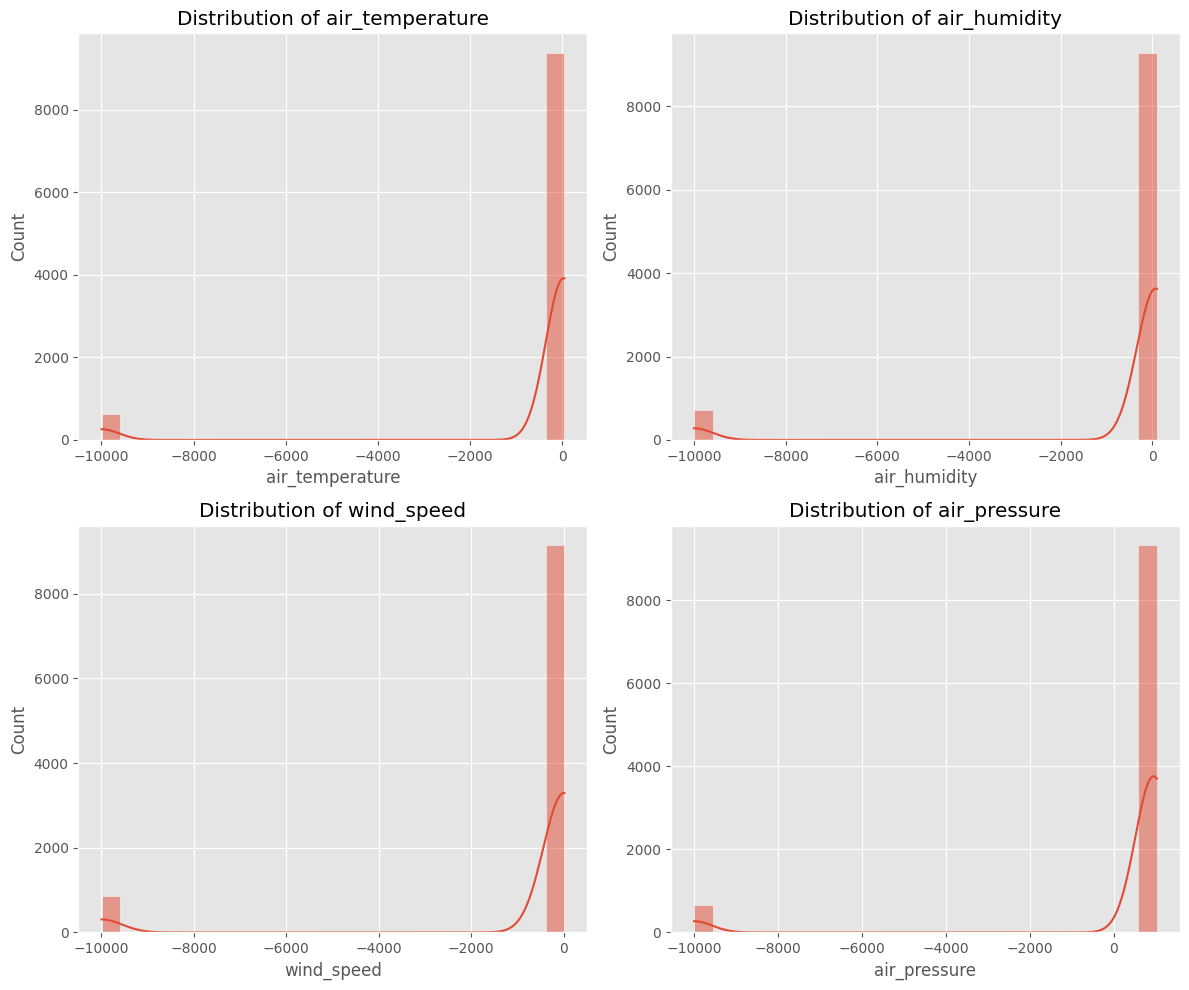

✅ Feature distribution plots created and saved as 'feature_distributions.png'


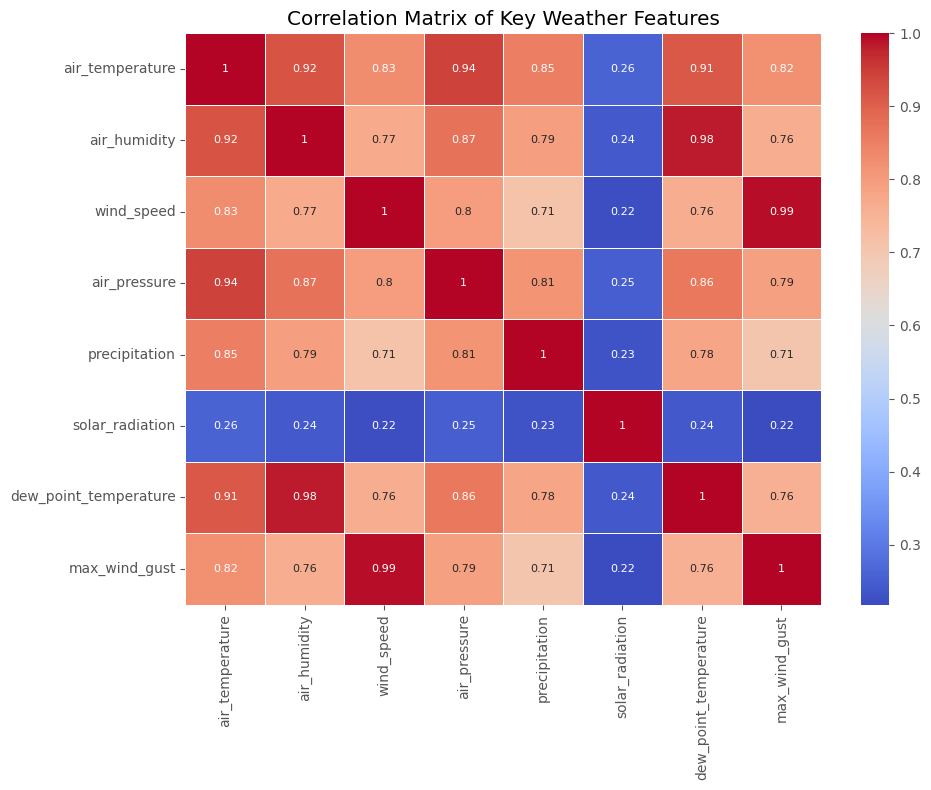

✅ Correlation matrix created and saved as 'correlation_matrix.png'
Step 4: Engineering features...
Step 5: Preprocessing data...
Step 6: Creating sequences (past=24, future=12)...
Step 7: Splitting data...
Step 8: Creating PyTorch datasets...
Data processing complete!
Training samples: 5358
Validation samples: 1148
Testing samples: 1149


In [ ]:
results = process_weather_data(
    file_path='southeast.csv',
    reduce_size=True,
    size_percentage=0.001,
    n_past=24,
    n_future=12,
    include_categorical=False,
    perform_feature_engineering=True,
    plot=True  # Skip plotting to save time
)

# Access the processed datasets
train_dataset = results['train_dataset']
val_dataset = results['val_dataset']
test_dataset = results['test_dataset']

TRAINING VAE AND CHECK FOR ANOMALY DETECTION

Step 1: Creating DataLoaders...
Step 2: Training VAE model...


  1%|          | 1/100 [00:01<03:00,  1.82s/it]

Epoch 1/100: Train Loss: 165.7016 (Recon: 145.1953, KL: 20.5062) | Val Loss: 237.2397 (Recon: 223.2856, KL: 13.9541)


  2%|▏         | 2/100 [00:02<01:41,  1.03s/it]

Epoch 2/100: Train Loss: 119.0805 (Recon: 94.3897, KL: 24.6909) | Val Loss: 188.0156 (Recon: 149.6080, KL: 38.4077)


  3%|▎         | 3/100 [00:02<01:16,  1.26it/s]

Epoch 3/100: Train Loss: 97.2924 (Recon: 61.7211, KL: 35.5714) | Val Loss: 185.3213 (Recon: 148.0739, KL: 37.2474)


  4%|▍         | 4/100 [00:03<01:04,  1.50it/s]

Epoch 4/100: Train Loss: 94.5917 (Recon: 58.3837, KL: 36.2080) | Val Loss: 182.8161 (Recon: 145.7444, KL: 37.0717)


  5%|▌         | 5/100 [00:03<00:57,  1.66it/s]

Epoch 5/100: Train Loss: 92.4098 (Recon: 55.8444, KL: 36.5654) | Val Loss: 177.8510 (Recon: 141.4501, KL: 36.4009)


  6%|▌         | 6/100 [00:04<00:52,  1.78it/s]

Epoch 6/100: Train Loss: 91.2307 (Recon: 54.2901, KL: 36.9405) | Val Loss: 178.8641 (Recon: 141.8804, KL: 36.9836)


  7%|▋         | 7/100 [00:04<00:50,  1.85it/s]

Epoch 7/100: Train Loss: 90.9260 (Recon: 53.3827, KL: 37.5433) | Val Loss: 176.0368 (Recon: 136.0801, KL: 39.9567)


  8%|▊         | 8/100 [00:05<00:47,  1.92it/s]

Epoch 8/100: Train Loss: 89.3959 (Recon: 51.7358, KL: 37.6601) | Val Loss: 175.9765 (Recon: 140.7278, KL: 35.2487)


  9%|▉         | 9/100 [00:05<00:46,  1.95it/s]

Epoch 9/100: Train Loss: 89.6555 (Recon: 51.4285, KL: 38.2270) | Val Loss: 179.5993 (Recon: 140.2007, KL: 39.3985)


 10%|█         | 10/100 [00:06<00:45,  1.99it/s]

Epoch 10/100: Train Loss: 88.7058 (Recon: 50.5543, KL: 38.1515) | Val Loss: 175.4494 (Recon: 138.8740, KL: 36.5753)


 11%|█         | 11/100 [00:06<00:44,  1.99it/s]

Epoch 11/100: Train Loss: 88.2171 (Recon: 50.1758, KL: 38.0414) | Val Loss: 169.2014 (Recon: 131.2282, KL: 37.9732)


 12%|█▏        | 12/100 [00:07<00:43,  2.02it/s]

Epoch 12/100: Train Loss: 90.1644 (Recon: 50.7670, KL: 39.3974) | Val Loss: 171.0064 (Recon: 131.1378, KL: 39.8686)


 13%|█▎        | 13/100 [00:07<00:42,  2.02it/s]

Epoch 13/100: Train Loss: 88.3910 (Recon: 49.3808, KL: 39.0102) | Val Loss: 166.8888 (Recon: 125.0011, KL: 41.8877)


 14%|█▍        | 14/100 [00:08<00:42,  2.04it/s]

Epoch 14/100: Train Loss: 88.3032 (Recon: 49.0785, KL: 39.2247) | Val Loss: 133.5058 (Recon: 83.4549, KL: 50.0509)


 15%|█▌        | 15/100 [00:08<00:46,  1.83it/s]

Epoch 15/100: Train Loss: 87.4351 (Recon: 48.1262, KL: 39.3090) | Val Loss: 116.8228 (Recon: 70.6839, KL: 46.1389)


 16%|█▌        | 16/100 [00:09<00:47,  1.78it/s]

Epoch 16/100: Train Loss: 89.1524 (Recon: 48.5798, KL: 40.5726) | Val Loss: 117.7280 (Recon: 70.4098, KL: 47.3181)


 17%|█▋        | 17/100 [00:10<00:48,  1.71it/s]

Epoch 17/100: Train Loss: 87.1473 (Recon: 47.1711, KL: 39.9762) | Val Loss: 130.2256 (Recon: 86.0472, KL: 44.1783)


 18%|█▊        | 18/100 [00:10<00:48,  1.68it/s]

Epoch 18/100: Train Loss: 87.1614 (Recon: 46.8952, KL: 40.2662) | Val Loss: 123.0861 (Recon: 75.4701, KL: 47.6160)


 19%|█▉        | 19/100 [00:11<00:50,  1.60it/s]

Epoch 19/100: Train Loss: 87.2946 (Recon: 46.8662, KL: 40.4285) | Val Loss: 119.4836 (Recon: 73.2227, KL: 46.2609)


 20%|██        | 20/100 [00:12<00:52,  1.53it/s]

Epoch 20/100: Train Loss: 86.7395 (Recon: 46.9353, KL: 39.8042) | Val Loss: 118.4768 (Recon: 70.9669, KL: 47.5099)


 21%|██        | 21/100 [00:12<00:53,  1.49it/s]

Epoch 21/100: Train Loss: 86.4460 (Recon: 46.4144, KL: 40.0316) | Val Loss: 120.7718 (Recon: 72.9969, KL: 47.7750)


 22%|██▏       | 22/100 [00:13<00:52,  1.48it/s]

Epoch 22/100: Train Loss: 86.7681 (Recon: 46.1244, KL: 40.6437) | Val Loss: 118.0229 (Recon: 73.6163, KL: 44.4066)


 23%|██▎       | 23/100 [00:14<00:48,  1.58it/s]

Epoch 23/100: Train Loss: 86.5799 (Recon: 46.1512, KL: 40.4287) | Val Loss: 126.2896 (Recon: 77.0492, KL: 49.2404)


 24%|██▍       | 24/100 [00:14<00:44,  1.71it/s]

Epoch 24/100: Train Loss: 86.9377 (Recon: 46.2960, KL: 40.6417) | Val Loss: 119.0871 (Recon: 74.6857, KL: 44.4014)


 25%|██▌       | 25/100 [00:15<00:41,  1.79it/s]

Epoch 25/100: Train Loss: 86.1327 (Recon: 45.7831, KL: 40.3496) | Val Loss: 107.0817 (Recon: 61.8770, KL: 45.2047)


 26%|██▌       | 26/100 [00:15<00:39,  1.87it/s]

Epoch 26/100: Train Loss: 85.6399 (Recon: 45.4210, KL: 40.2189) | Val Loss: 119.0524 (Recon: 77.7494, KL: 41.3031)


 27%|██▋       | 27/100 [00:15<00:38,  1.92it/s]

Epoch 27/100: Train Loss: 85.9567 (Recon: 45.3061, KL: 40.6505) | Val Loss: 118.1033 (Recon: 75.3602, KL: 42.7431)


 28%|██▊       | 28/100 [00:16<00:36,  1.97it/s]

Epoch 28/100: Train Loss: 87.4608 (Recon: 46.2171, KL: 41.2437) | Val Loss: 147.6559 (Recon: 103.9275, KL: 43.7284)


 29%|██▉       | 29/100 [00:16<00:35,  1.99it/s]

Epoch 29/100: Train Loss: 85.2249 (Recon: 44.8254, KL: 40.3995) | Val Loss: 116.2073 (Recon: 71.0607, KL: 45.1467)


 30%|███       | 30/100 [00:17<00:35,  2.00it/s]

Epoch 30/100: Train Loss: 86.7623 (Recon: 45.3324, KL: 41.4299) | Val Loss: 124.8155 (Recon: 79.8164, KL: 44.9992)


 31%|███       | 31/100 [00:17<00:34,  2.00it/s]

Epoch 31/100: Train Loss: 85.5734 (Recon: 44.5471, KL: 41.0263) | Val Loss: 118.8103 (Recon: 76.5794, KL: 42.2309)


 32%|███▏      | 32/100 [00:18<00:33,  2.01it/s]

Epoch 32/100: Train Loss: 86.1325 (Recon: 44.9778, KL: 41.1547) | Val Loss: 119.3954 (Recon: 76.7926, KL: 42.6028)


 33%|███▎      | 33/100 [00:18<00:32,  2.03it/s]

Epoch 33/100: Train Loss: 86.0380 (Recon: 45.4325, KL: 40.6055) | Val Loss: 115.4853 (Recon: 73.3950, KL: 42.0904)


 34%|███▍      | 34/100 [00:19<00:32,  2.04it/s]

Epoch 34/100: Train Loss: 85.5001 (Recon: 44.7630, KL: 40.7372) | Val Loss: 116.8266 (Recon: 73.6539, KL: 43.1727)


 34%|███▍      | 34/100 [00:19<00:38,  1.71it/s]

Epoch 35/100: Train Loss: 85.6989 (Recon: 45.1256, KL: 40.5733) | Val Loss: 116.9444 (Recon: 70.2792, KL: 46.6652)
Early stopping at epoch 35


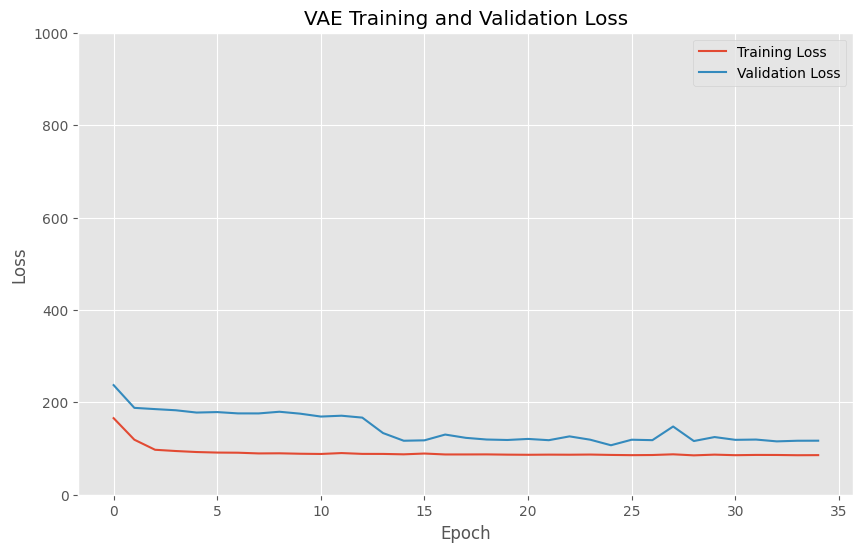

Step 3: Detecting anomalies in test data...
Anomaly scores : 7.128054141998291
Anomalies : [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Threshold : 152.63429498672485
Step 4: Filtering anomalies from training data...


In [ ]:
n_past=24
n_future=12
vae_latent_dim=8
gru_hidden_dim=64
batch_size=64
vae_epochs=100

print("Step 1: Creating DataLoaders...")
train_loader_vae = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_vae = DataLoader(val_dataset, batch_size=batch_size)
test_loader_vae = DataLoader(test_dataset, batch_size=batch_size)

input_dim = train_dataset.X.shape[2]


print("Step 2: Training VAE model...")
vae_model = VAE(input_dim=input_dim,
                hidden_dims=[128, 64],
                latent_dim=vae_latent_dim).to(device)

trained_vae, vae_train_losses, vae_val_losses = train_vae(
    vae_model,
    train_loader_vae,
    val_loader_vae,
    epochs=vae_epochs,
    device=device
)


print("Step 3: Detecting anomalies in test data...")
anomaly_scores, anomalies, threshold = detect_anomalies(
    trained_vae,
    test_loader_vae,
    device=device
)

print(f"Anomaly scores : {np.mean(anomaly_scores)}")
print(f"Anomalies : {anomalies}")
print(f"Threshold : {threshold}")

print("Step 4: Filtering anomalies from training data...")


TRAINING GRU AND PLOTTING THE FORECASTING

Step 4: Filtering anomalies from training data...
Step 5: Training GRU model for forecasting...
Epoch 1/30: Train Loss: 0.824580, Val Loss: 0.818687, Teacher Forcing: 0.80
Epoch 2/30: Train Loss: 0.805696, Val Loss: 0.818519, Teacher Forcing: 0.79
Epoch 3/30: Train Loss: 0.799697, Val Loss: 0.818269, Teacher Forcing: 0.78
Epoch 4/30: Train Loss: 0.790067, Val Loss: 0.817678, Teacher Forcing: 0.77
Epoch 5/30: Train Loss: 0.790152, Val Loss: 0.820679, Teacher Forcing: 0.76
Epoch 6/30: Train Loss: 0.784301, Val Loss: 0.817547, Teacher Forcing: 0.75
Epoch 7/30: Train Loss: 0.778224, Val Loss: 0.826810, Teacher Forcing: 0.74
Epoch 8/30: Train Loss: 0.770185, Val Loss: 0.822411, Teacher Forcing: 0.73
Epoch 9/30: Train Loss: 0.762828, Val Loss: 0.819674, Teacher Forcing: 0.72
Epoch 10/30: Train Loss: 0.768164, Val Loss: 0.831696, Teacher Forcing: 0.71
Epoch 11/30: Train Loss: 0.762923, Val Loss: 0.839352, Teacher Forcing: 0.70
Early stopping at epoch 11


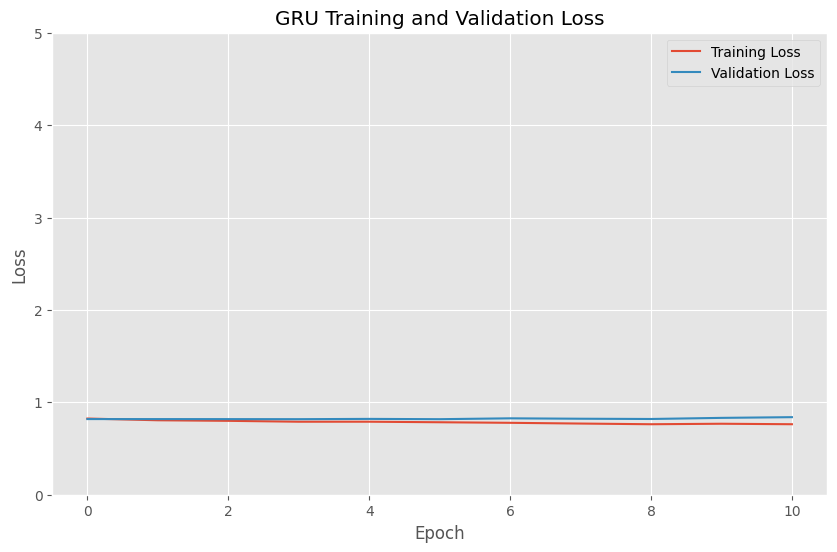

Step 6: Evaluating GRU model performance...
Predictions shape: (1149, 240)
Targets shape: (1149, 240)


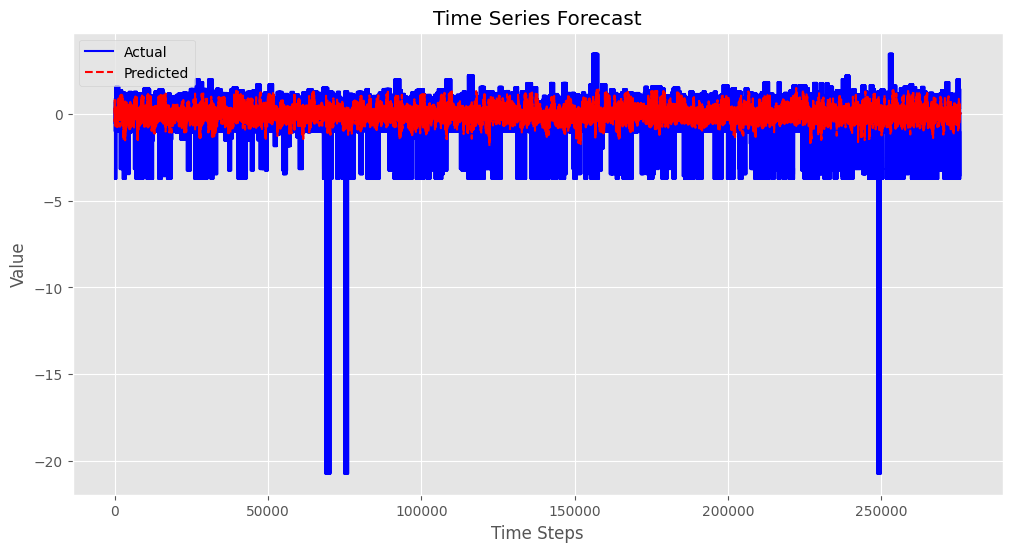

Step 7: Analyzing latent space representations...
Latent vector shape before PCA: (1149, 24, 8)


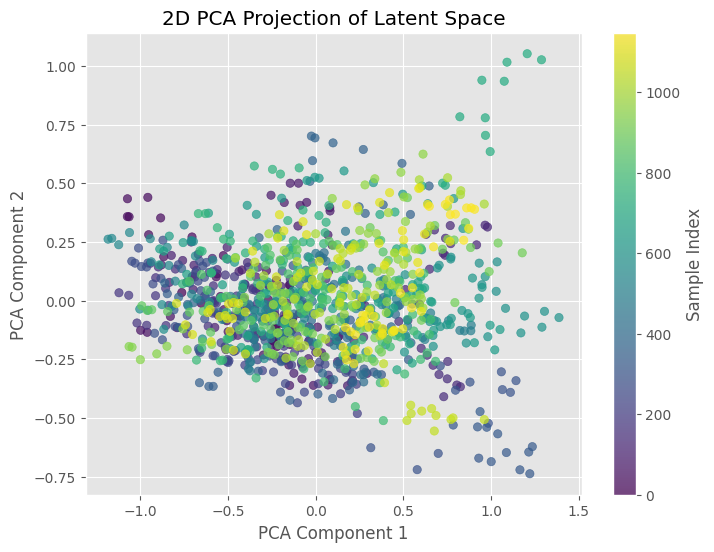

Step 8: Generating synthetic weather data samples...


In [ ]:

print("Step 4: Filtering anomalies from training data...")
train_loader_gru = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_gru = DataLoader(val_dataset, batch_size=batch_size)
test_loader_gru = DataLoader(test_dataset, batch_size=batch_size)

print("Step 5: Training GRU model for forecasting...")
gru_model = Seq2SeqGRU(
    input_dim=input_dim,
    hidden_dim=gru_hidden_dim,
    output_seq_len=n_future,
    n_layers=2,
    dropout=0.3
).to(device)

def teacher_forcing_schedule(epoch):
    return max(0.0, 0.8 - 0.01 * epoch)

gru_epochs=30

trained_gru, gru_train_losses, gru_val_losses = train_gru(
    gru_model,
    train_loader_gru,
    val_loader_gru,
    epochs=gru_epochs,
    teacher_forcing_schedule=teacher_forcing_schedule,
    device=device
)

print("Step 6: Evaluating GRU model performance...")
gru_metrics, predictions, targets = evaluate_gru(
    trained_gru,
    test_loader_gru,
    device=device
)

visualize_forecast_from_loader(test_loader_gru, predictions, targets)

print("Step 7: Analyzing latent space representations...")
latent_vectors, original_samples = analyze_latent_space(
    trained_vae,
    test_loader_vae,
    device=device
)

print("Step 8: Generating synthetic weather data samples...")
synthetic_data = generate_synthetic_data(trained_vae, n_samples=1000, device=device)


VIEWING SYNTHETIC DATA PRODUCED

In [ ]:
print(synthetic_data)

[[ 0.23992807  0.2776778   0.276775   ... -0.17701842 -0.5303103
   0.44973266]
 [ 0.22281149  0.28423196  0.28032288 ... -0.5053377  -1.087779
   0.0153401 ]
 [ 0.21530163  0.28378278  0.27630776 ... -0.5187692  -1.2786424
  -0.09023106]
 ...
 [ 0.23448323  0.28104895  0.28440282 ... -0.03664225  0.5099935
  -0.27134645]
 [ 0.24050188  0.27147177  0.2713306  ... -0.15316704 -0.5590461
   0.37933433]
 [ 0.22479708  0.27788436  0.27500123 ... -0.32281408 -0.9355224
   0.23396024]]


CREATING A DATAFRAME OBJECT OF RESULTS


In [ ]:
 # Inverse transform synthetic data if scaler is available (assuming scaler is accessible globally or passed separately)
results = {
    'trained_vae': trained_vae,
    'trained_gru': trained_gru,

    'anomaly_detection': {
        'scores': anomaly_scores,
        'anomalies': anomalies,
        'threshold': threshold
    },

    'forecasting': {
        'metrics': gru_metrics,
        'predictions': predictions,
        'targets': targets
    },

    'latent_space_analysis': latent_vectors,

    'synthetic_data_samples': synthetic_data,

    'train_losses': {
        'vae_train_losses': vae_train_losses,
        'gru_train_losses': gru_train_losses
     },

     'val_losses': {
        'vae_val_losses': vae_val_losses,
        'gru_val_losses': gru_val_losses
     }
 }

In [ ]:

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        elif isinstance(v, (list, np.ndarray)):
            items.append((new_key, list(v)))
        else:
            items.append((new_key, v))
    return dict(items)

flattened_results = flatten_dict(results)
df = pd.DataFrame([flattened_results])
print(df.head())


SUMMARY OF ALL THE RESULTS


In [ ]:
# Summary of Results
print("\nSummary of Results:")

# Total number of samples in test dataset
total_test_samples = len(test_dataset)

# Number of anomalies detected in test dataset
num_anomalies_detected = results['anomaly_detection']['anomalies'].sum()

print(f"Anomalies detected: {num_anomalies_detected} out of {total_test_samples} test samples")

# Forecasting metrics (assuming results['forecasting']['metrics'] contains 'mse' and 'mae')
forecast_mse = results['forecasting']['metrics']['MSE']
forecast_mae = results['forecasting']['metrics']['MAE']

print(f"Forecasting RMSE: {np.sqrt(forecast_mse):.4f}")
print(f"Forecasting MAE: {forecast_mae:.4f}")



Summary of Results:
Anomalies detected: 78 out of 1149 test samples
Forecasting RMSE: 1.3610
Forecasting MAE: 0.7273
